In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [3]:
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {desc[0]: desc[1](mol) for desc in Descriptors._descList}
    else:
        return {desc[0]: None for desc in Descriptors._descList}

# Replace the file path with your actual data file path
data_path = 'tested_molecules.csv'
data = pd.read_csv(data_path)
data['descriptors'] = data['SMILES'].apply(calculate_descriptors)
descriptors_df = pd.DataFrame(data['descriptors'].tolist())
descriptors_df['SMILES']=data['SMILES']
descriptors_df['PKM2_inhibition']=data['PKM2_inhibition']
descriptors_df['ERK2_inhibition']=data['ERK2_inhibition']                               
descriptors_df.fillna(descriptors_df.mean(), inplace=True)
descriptors_df.head(1)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILES,PKM2_inhibition,ERK2_inhibition
0,5.313889,0.120833,5.313889,0.120833,0.592228,151.173,142.101,151.085795,58,0,...,0,0,0,0,0,0,0,C=C(C)c1nc(N)nc(N)n1,0,0


In [4]:
descriptors_df.head()
pca_descriptors= descriptors_df.drop(columns=['SMILES','PKM2_inhibition','ERK2_inhibition'])
scaling=MinMaxScaler()
scaling.fit(pca_descriptors)
df_pca_scaled = scaling.transform(pca_descriptors)
# Perform PCA analysis
principal_components = PCA(n_components=208)
principal_components.fit(df_pca_scaled)
pca_transformed = principal_components.transform(df_pca_scaled)

The variance in the first prinicpal component is 18%


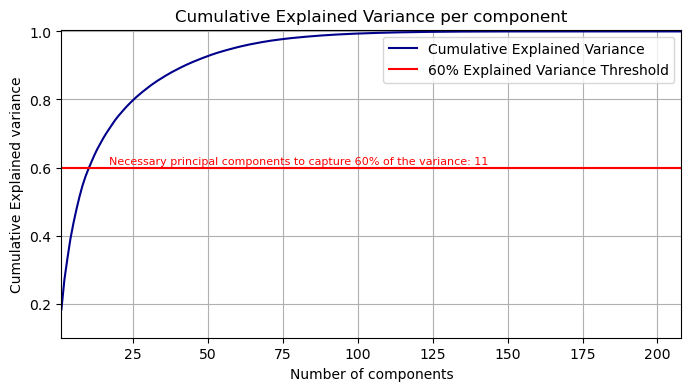

In [5]:
# Determine variance and cumulative variance
variance = principal_components.explained_variance_ratio_
sum_variance = np.zeros(len(variance)) # Initialize an array for cumulative variance
for i in range(len(variance)):
    sum_variance[i] = sum(variance[0:i+1])

# Determine the amount of principal components to capture 90% variance
threshold_component = np.where(sum_variance > 0.60)[0][0] # Component at which the cumulative variance is higher than 0.9

# Variance in the first component
first_component = sum_variance[0]*100
print(f'The variance in the first prinicpal component is {first_component:.0f}%')

plt.figure(figsize=(8,4))
plt.plot(range(1,len(variance)+1),sum_variance , color='darkblue')
plt.text(threshold_component+7, 0.61, f'Necessary principal components to capture 60% of the variance: {threshold_component+1}', fontsize=8, color='r')
plt.axhline(y=0.6, color='r')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')
plt.ylim(0.1,1.005)
plt.legend(['Cumulative Explained Variance', '60% Explained Variance Threshold'])
plt.xlim(1,208)
plt.grid()
plt.title('Cumulative Explained Variance per component')
plt.show()

In [13]:

# Extract the eigenvalues from the first principal component
top_descriptors = []
for i in range(11):
    pca_eigenvalue = principal_components.components_[i]
    absolute_eigenvalue = np.abs(pca_eigenvalue)
    df_eigenvalues = pd.DataFrame(absolute_eigenvalue, columns=['Eigenvalue']) # Create dataframe for visualisation
    df_eigenvalues['Descriptor'] = pca_descriptors.columns # Add the features
    df_sort = df_eigenvalues.sort_values(by='Eigenvalue', ascending=False) # Sort them on eigenvalue
    #print(df_sort.head(10)) # Print the top 10 eigenvalues

    top_10_descriptors = df_sort['Descriptor'].head(10).tolist() # Get the top 10 descriptors
    top_descriptors.extend(top_10_descriptors) # Add them to the list

# Remove duplicates
top_descriptors = list(set(top_descriptors))

print(len(top_descriptors))

77


Check the distribution of classes in the data

In [8]:
pkm2 = descriptors_df['PKM2_inhibition'].value_counts()
print(pkm2)
erk2 = descriptors_df['ERK2_inhibition'].value_counts()
print(erk2)

0    1088
1      28
Name: PKM2_inhibition, dtype: int64
0    1065
1      51
Name: ERK2_inhibition, dtype: int64


Precision: 0.0
Precision: 0.5
Recall: 0.0
Recall: 0.16666666666666666


c:\Users\20212598\.conda\envs\8cc00-group-assignment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


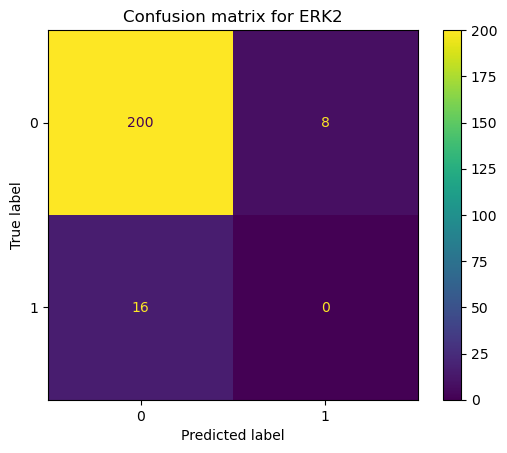

c:\Users\20212598\.conda\envs\8cc00-group-assignment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


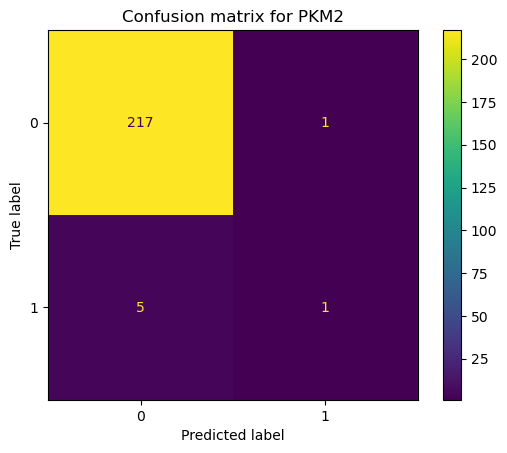

In [14]:
selected_descriptors_df = descriptors_df[top_descriptors]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

# Stel dat 'erk2' en 'pkm2' de namen zijn van je target variabelen
y_erk2 = descriptors_df['ERK2_inhibition']
y_pkm2 = descriptors_df['PKM2_inhibition']

# Splits de data in een trainset en een testset
X_train, X_test, y_train_erk2, y_test_erk2 = train_test_split(selected_descriptors_df, y_erk2, test_size=0.2, random_state=42)
_, _, y_train_pkm2, y_test_pkm2 = train_test_split(selected_descriptors_df, y_pkm2, test_size=0.2, random_state=42)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Maak een lineaire regressie model
model_erk2 = LogisticRegression(class_weight={0:1,1:5})#class_weight='balanced')
model_pkm2 = LogisticRegression(class_weight={0:1,1:5})#class_weight='balanced')

# Train het model
model_erk2.fit(X_train, y_train_erk2)
model_pkm2.fit(X_train, y_train_pkm2)

# Maak voorspellingen op de testset
predictions_erk2 = model_erk2.predict(X_test)
predictions_pkm2 = model_pkm2.predict(X_test)

# Bereken de precisie en recall
precision_erk2 = precision_score(y_test_erk2, predictions_erk2)
precision_pkm2 = precision_score(y_test_pkm2, predictions_pkm2)

recall_erk2 = recall_score(y_test_erk2, predictions_erk2)
recall_pkm2 = recall_score(y_test_pkm2, predictions_pkm2)

print(f"Precision: {precision_erk2}")
print(f"Precision: {precision_pkm2}")
print(f"Recall: {recall_erk2}")
print(f"Recall: {recall_pkm2}")

plot_confusion_matrix(model_erk2,X_test, y_test_erk2)
plt.title('Confusion matrix for ERK2')
plt.show()
# Bereken de confusion matrix voor PKM2
plot_confusion_matrix(model_pkm2, X_test, y_test_pkm2)
plt.title('Confusion matrix for PKM2')
plt.show()


In [15]:
pkm2 = descriptors_df['PKM2_inhibition'].value_counts()
print(pkm2)
erk2 = descriptors_df['ERK2_inhibition'].value_counts()
print(erk2)


0    1088
1      28
Name: PKM2_inhibition, dtype: int64
0    1065
1      51
Name: ERK2_inhibition, dtype: int64


1    870
0    870
Name: PKM2_inhibition, dtype: int64
1    857
0    857
Name: ERK2_inhibition, dtype: int64
Precision: 0.058823529411764705
Precision: 0.12
Recall: 0.0625
Recall: 0.5


c:\Users\20212598\.conda\envs\8cc00-group-assignment\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\20212598\.conda\envs\8cc00-group-assignment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


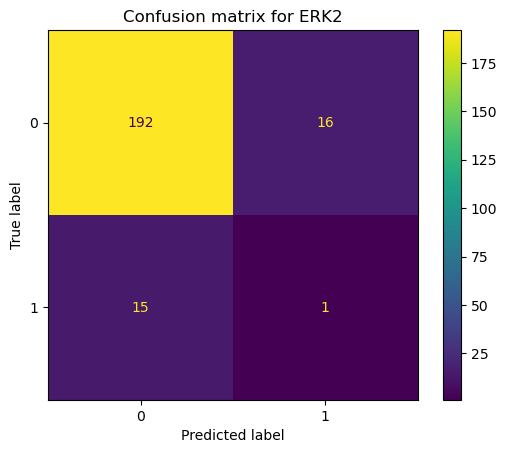

c:\Users\20212598\.conda\envs\8cc00-group-assignment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


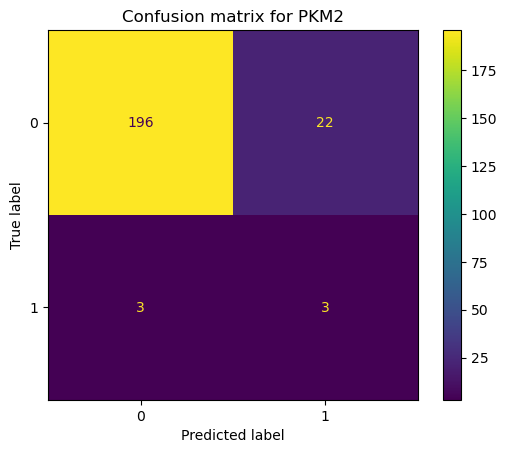

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE

# Splits de data in een trainset en een testset
selected_descriptors_df = descriptors_df[top_descriptors]
X_train_erk, X_test_e, y_train_erk, y_test_e = train_test_split(selected_descriptors_df, descriptors_df['ERK2_inhibition'], test_size=0.2, random_state=42)
X_train_pkm, X_test_p, y_train_pkm, y_test_p = train_test_split(selected_descriptors_df, descriptors_df['PKM2_inhibition'], test_size=0.2, random_state=42)




# Maak een SMOTE object
smote = SMOTE(random_state=42)
X_train_e, y_train_e = smote.fit_resample(X_train_erk,y_train_erk)
X_train_p, y_train_p = smote.fit_resample(X_train_pkm, y_train_pkm)
print(y_train_p.value_counts())
print(y_train_e.value_counts())



# Scale data
scaler = MinMaxScaler()
X_train_e = scaler.fit_transform(X_train_e)
X_test_e = scaler.transform(X_test_e)

X_train_p = scaler.fit_transform(X_train_p)
X_test_p = scaler.transform(X_test_p)


# Maak een lineaire regressie model
model_erk2 = LogisticRegression()#class_weight='balanced')
model_pkm2 = LogisticRegression()#class_weight='balanced')

# Train het model
model_erk2.fit(X_train_e, y_train_e)
model_pkm2.fit(X_train_p, y_train_p)

# Maak voorspellingen op de testset
predictions_erk2 = model_erk2.predict(X_test_e)
predictions_pkm2 = model_pkm2.predict(X_test_p)

# Bereken de precisie en recall
precision_erk2 = precision_score(y_test_e, predictions_erk2)
precision_pkm2 = precision_score(y_test_p, predictions_pkm2)

recall_erk2 = recall_score(y_test_e, predictions_erk2)
recall_pkm2 = recall_score(y_test_p, predictions_pkm2)

print(f"Precision: {precision_erk2}")
print(f"Precision: {precision_pkm2}")
print(f"Recall: {recall_erk2}")
print(f"Recall: {recall_pkm2}")

plot_confusion_matrix(model_erk2,X_test_e, y_test_e)
plt.title('Confusion matrix for ERK2')
plt.show()
# Bereken de confusion matrix voor PKM2
plot_confusion_matrix(model_pkm2, X_test_p, y_test_p)
plt.title('Confusion matrix for PKM2')
plt.show()
